# 6. Variable free stream
In this notebook we will simulate the flow with a time-varying free stream past a
stationary body. To demonstrate this, we will solve for oscillatory flow past a
rectangular object, in which the $x$ component of the free stream is

$$U_\infty(t) = A \sin(\Omega t)$$

In [1]:
using ViscousFlow

In [2]:
using Plots

### Problem specification
We will set the Reynolds number to 200

In [3]:
Re = 200 # Reynolds number

200

In order to set the time-varying free stream, we will use the `OscillationX` function,
which generates a set of oscillatory kinematics. Type `?OscillationX` to
learn more.

Since we are using this function to specify the velocity (the first derivative of
the position), then we set

In [4]:
Ux = 0.0
Ω  = 1.0
Ax = 1.0
fs = OscillationX(Ux,Ω,Ax,π/2)

Oscillatory kinematics with
     Steady velocity U = (0.0,0.0)
     Ref angle α₀ = 0.0
     Mean rotation rate α̇₀ = 0.0
     Pitch axis (rel. to centroid) a = (0.0,0.0)
     Frequency Ω = 1.0
     x amplitude Ax, phase lag ϕx = (1.0, 1.5707963267948966)
     y amplitude Ay, phase lag ϕy = (0.0, 0.0)
     α amplitude Δα, phase lag ϕα = (0.0, 0.0)


As with body motion, it is useful to verify that this provides the expected behavior
by plotting it:

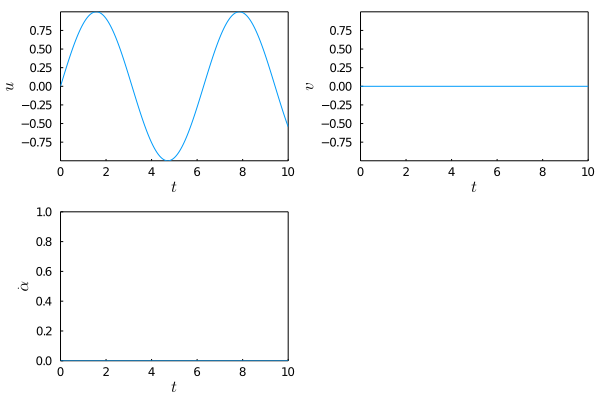

In [5]:
plot(fs)

Now let us carry on with the other usual steps:

### Discretize

In [6]:
xlim = (-2.0,2.0)
ylim = (-1.5,1.5)

Δx, Δt = setstepsizes(Re,gridRe=3.0)

(0.015, 0.0075)

### Set up bodies
Here, we will set up a rectangle in the center of the domain

In [7]:
body = Rectangle(0.25,0.5,1.5Δx)
T = RigidTransform((0.0,0.0),0.0)
T(body)

Rectangular body with 126 points and half-lengths (0.25,0.5)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


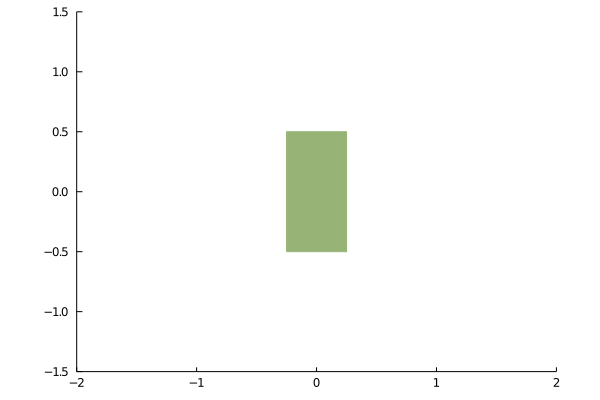

In [8]:
plot(body,xlim=xlim,ylim=ylim)

### Construct the system structure
This step is like the previous notebook, but now we also provide the body and the freestream:

In [9]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,body,freestream = fs)

External flow Navier-Stokes system on a grid of size 270 x 208 and 126 static immersed points
   Variable freestream
   1 body


### Initialize
Now, we initialize with zero vorticity

In [10]:
u0 = newstate(sys)

(Dual nodes in a (nx = 270, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 270, ny = 208), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

and create the integrator

In [11]:
tspan = (0.0,10.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 270, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 270, ny = 208), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

### Solve
Now we are ready to solve the problem. Let's advance the solution to $t = 1$.

In [12]:
@time step!(integrator,1.0)
sol = integrator.sol;

 28.410219 seconds (9.48 M allocations: 2.725 GiB, 1.13% gc time)


### Examine
Let's look at the flow field at the end of this interval

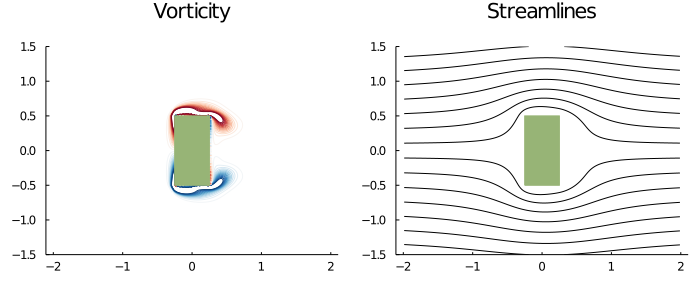

In [13]:
plot(
plot(vorticity(integrator),sys,title="Vorticity",clim=(-10,10),levels=range(-10,10,length=30), color = :RdBu,ylim=ylim),
plot(streamfunction(integrator),sys,title="Streamlines",ylim=ylim,color = :Black),
    size=(700,300)
    )

Now let's make a movie

┌ Info: Saved animation to 
│   fn = /var/folders/1s/lds3nd1s7xn4mgf0vxqwg0kr0000gn/T/jl_oCVVDp.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/6EMd6/src/animation.jl:104


Plots.AnimatedGif("/var/folders/1s/lds3nd1s7xn4mgf0vxqwg0kr0000gn/T/jl_oCVVDp.gif")
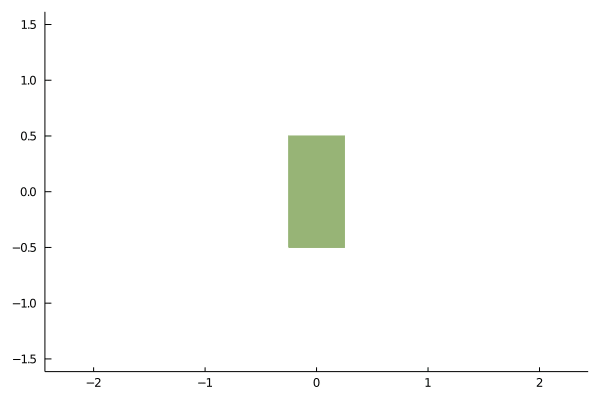

In [14]:
@gif for (u,t) in zip(sol.u,sol.t)
    #plot(streamfunction(u,sys,t),sys, color = :Black)
    plot(vorticity(u,sys,t),sys,clim=(-10,10),levels=range(-10,10,length=30), color = :RdBu)
    end every 10

#### Compute the force history
Just as we did for the stationary body in a constant free stream

In [15]:
fx, fy = force(sol,sys,1);

Plot them

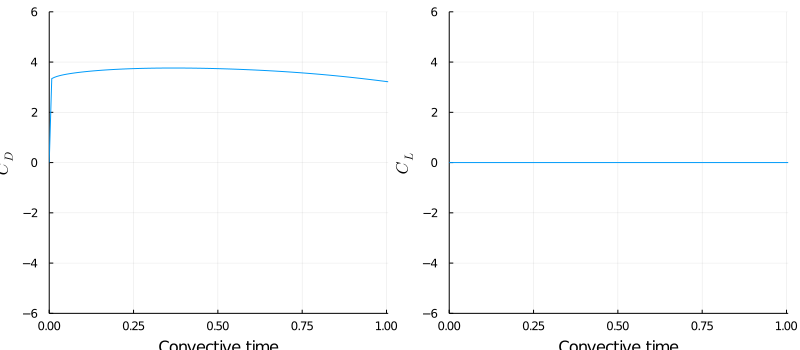

In [16]:
plot(
plot(sol.t,2*fx,xlim=(0,Inf),ylim=(-6,6),xlabel="Convective time",ylabel="\$C_D\$",legend=:false),
plot(sol.t,2*fy,xlim=(0,Inf),ylim=(-6,6),xlabel="Convective time",ylabel="\$C_L\$",legend=:false),
    size=(800,350)
)

The mean drag and lift coefficients are

In [17]:
meanCD = GridUtilities.mean(2*fx)

3.582052882696855

In [18]:
meanCL = GridUtilities.mean(2*fy)

7.32929532956852e-15

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*